Name: Qiaochu Dai

Githubname: Levi519519

USCID: 7326115044

### 1. Multi-class and Multi-Label Classification Using Support Vector Machines

#### (a) Download the Anuran Calls (MFCCs) Data Set from: https://archive.ics.uci.edu/ml/datasets/Anuran+Calls+%28MFCCs%29. Choose 70% of the data randomly as the training set.

In [206]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabasz_score
from PIL import Image
from IPython.display import display

In [13]:
path='../data/Anuran Calls (MFCCs)/Frogs_MFCCs.csv'
df=pd.read_csv(path)
y=df.iloc[:,-4:-1]
X=df.iloc[:,0:-4]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
y_train

,Family,Genus,Species
2004,Leptodactylidae,Adenomera,AdenomeraHylaedactylus
1194,Dendrobatidae,Ameerega,Ameeregatrivittata
5359,Hylidae,Hypsiboas,HypsiboasCinerascens
1756,Leptodactylidae,Adenomera,AdenomeraHylaedactylus
497,Leptodactylidae,Adenomera,AdenomeraAndre
...,...,...,...
3772,Leptodactylidae,Adenomera,AdenomeraHylaedactylus
5191,Hylidae,Hypsiboas,HypsiboasCinerascens
5226,Hylidae,Hypsiboas,HypsiboasCinerascens
5390,Hylidae,Hypsiboas,HypsiboasCinerascens


#### (b) Each instance has three labels: Families, Genus, and Species. Each of the labels has multiple classes. We wish to solve a multi-class and multi-label problem. One of the most important approaches to multi-label classification is to train a classifier for each label (binary relevance). We first try this approach:

##### i. Research exact match and hamming score/ loss methods for evaluating multi- label classification and use them in evaluating the classifiers in this problem.

1. exact match: In multi-label classification, each instance can belong to multiple classes simultaneously, and exact match evaluation checks if the predicted labels match the true labels for each instance entirely.

2. hamming score: Hamming score is a measure of how many labels are correctly predicted for the entire dataset.

##### ii. Train a SVM for each of the labels, using Gaussian kernels and one versus all classifiers. Determine the weight of the SVM penalty and the width of the Gaussian Kernel using 10 fold cross validation.1 You are welcome to try to solve the problem with both standardized 2 and raw attributes and report the results.

In [94]:
def get_C_and_gamma(param_grid,X_train,y_train, L1_penalized_SVM=False):
    if L1_penalized_SVM:
        grid_search = GridSearchCV(LinearSVC(penalty='l1', dual=False,max_iter=10000), param_grid, cv=10, scoring='f1_weighted', verbose=1)
    else:
        grid_search = GridSearchCV(SVC(kernel='rbf'), param_grid, cv=10, scoring='accuracy')
    
    grid_search.fit(X_train, y_train)

    if L1_penalized_SVM:
        best_C = grid_search.best_params_['C']
        return best_C
    else:
        best_C = grid_search.best_params_['C']
        best_gamma = grid_search.best_params_['gamma']
        return best_C, best_gamma

def get_hamming_score(y_test,y_pred):
    n=3*len(y_test)
    score=0
    for j in range(0,len(y_test.columns)):
        for i in range(0,len(y_test)):
            if y_test.iloc[i,j]==y_pred.iloc[i,j]:
                score+=1
    score=score/n
    return score

def get_exact_match(y_test,y_pred):
    n=len(y_test)
    final_score=0
    for i in range(0,len(y_test)):
        score=0
        for j in range(0,len(y_test.columns)):
            if y_test.iloc[i,j]==y_pred.iloc[i,j]:
                score+=1
        if score==len(y_test.columns):
            final_score+=1
    final_score=final_score/n
    return final_score

In [34]:
param_grid = {'C' : np.logspace(-5, 5, 11), 
                'gamma' : np.logspace(-3, 6, 10)}
y_pred = []
for label in y_train.columns:
    best_C, best_gamma=get_C_and_gamma(param_grid,X_train,y_train[label])
    print(f'For label {label}, best C equals to {best_C} and best gamma equals to {best_gamma}')
    svm = SVC(C=best_C, gamma=best_gamma, kernel='rbf')
    svm.fit(X_train, y_train[label])
    y_pred_label = svm.predict(X_test)
    y_pred.append(y_pred_label)

In [66]:
y_pred=pd.DataFrame(y_pred)
y_pred=y_pred.T
column_mapping = {old_col: new_col for old_col, new_col in zip(y_pred.columns, y_train.columns)}
y_pred = y_pred.rename(columns=column_mapping)
result={}
result['exact_match']=[get_exact_match(y_test,y_pred)]
result['hamming_score']=[get_hamming_score(y_test,y_pred)]
result=pd.DataFrame(result)
result

,exact_match,hamming_score
0,0.986105,0.991663


##### iii. Repeat 1(b)ii with L1-penalized SVMs.3 Remember to standardize4 the at- tributes. Determine the weight of the SVM penalty using 10 fold cross vali- dation.

In [98]:
param_grid = {'C' : np.logspace(1, 5, 10)}
std_scaler = StandardScaler()
X_train = std_scaler.fit_transform(X_train)
X_test = std_scaler.fit_transform(X_test)

In [99]:
y_pred2 = []
for label in y_train.columns:
    best_C=get_C_and_gamma(param_grid,X_train,y_train[label],L1_penalized_SVM=True)
    print(f'For label {label}, best C equals to {best_C}')
    svm = LinearSVC(penalty='l1',C=best_C, dual=False)
    svm.fit(X_train, y_train[label])
    y_pred_label2 = svm.predict(X_test)
    y_pred2.append(y_pred_label2)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number 

Fitting 10 folds for each of 10 candidates, totalling 100 fits


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number 

In [107]:
y_pred2=pd.DataFrame(y_pred2)
y_pred2=y_pred2.T
column_mapping = {old_col: new_col for old_col, new_col in zip(y_pred2.columns, y_train.columns)}
y_pred2 = y_pred2.rename(columns=column_mapping)
result2={}
result2['exact_match']=[get_exact_match(y_test,y_pred2)]
result2['hamming_score']=[get_hamming_score(y_test,y_pred2)]
result2=pd.DataFrame(result2)
result2

,exact_match,hamming_score
0,0.909217,0.941331


##### iv. Repeat 1(b)iii by using SMOTE or any other method you know to remedy class imbalance. Report your conclusions about the classifiers you trained.


In [109]:
def perform_SMOTE(X_train, y_train):
    smote = SMOTE(sampling_strategy='auto', random_state=42) 
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
    return X_train_resampled, y_train_resampled

In [111]:
y_pred3 = []
for label in y_train.columns:
    X_train_trans,y_train_trans=perform_SMOTE(X_train, y_train[label])
    best_C=get_C_and_gamma(param_grid,X_train_trans,y_train_trans,L1_penalized_SVM=True)
    print(f'For label {label}, best C equals to {best_C}')
    svm = LinearSVC(penalty='l1',C=best_C, dual=False)
    svm.fit(X_train_trans, y_train_trans)
    y_pred_label3 = svm.predict(X_test)
    y_pred3.append(y_pred_label3)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [118]:
y_pred3=pd.DataFrame(y_pred3)
y_pred3=y_pred3.T
column_mapping = {old_col: new_col for old_col, new_col in zip(y_pred3.columns, y_train.columns)}
y_pred3 = y_pred3.rename(columns=column_mapping)
result3={}
result3['exact_match']=[get_exact_match(y_test,y_pred3)]
result3['hamming_score']=[get_hamming_score(y_test,y_pred3)]
result3=pd.DataFrame(result3)
result3

,exact_match,hamming_score
0,0.866605,0.926818


In [123]:
result_all=pd.concat([result, result2], axis=0)
result_all=pd.concat([result_all, result3], axis=0)
result_all.index=['SVM using Gaussian kernels','L1-penalized SVMs','SMOTE']
result_all

,exact_match,hamming_score
SVM using Gaussian kernels,0.986105,0.991663
L1-penalized SVMs,0.909217,0.941331
SMOTE,0.866605,0.926818


### 2. K-Means Clustering on a Multi-Class and Multi-Label Data Set

### Monte-Carlo Simulation: Perform the following procedures 50 times, and report the average and standard deviation of the 50 Hamming Distances that you calculate.

#### (a) Use k-means clustering on the whole Anuran Calls (MFCCs) Data Set (do not split the data into train and test, as we are not performing supervised learning in this exercise). Choose k ∈ {1, 2, . . . , 50} automatically based on one of the methods provided in the slides (CH or Gap Statistics or scree plots or Silhouettes) or any other method you know.

In [191]:
def get_best_k(X,iteration):
    k_values = range(2,51)
    ch_scores = []

    for k in k_values:
        kmeans = KMeans(n_clusters=k,random_state=iteration)
        labels = kmeans.fit_predict(X)
        ch_score = calinski_harabasz_score(X, labels)
        ch_scores.append(ch_score)

    best_k = k_values[ch_scores.index(max(ch_scores))]
    return best_k

def cluster_to_label(X,y,iteration):
    best_k = get_best_k(X,iteration)
    kmeans = KMeans(n_clusters=best_k,random_state=iteration)
    labels = kmeans.fit_predict(X)
    pre_label=pd.DataFrame(index=range(best_k),columns=y.columns)
    for i in range(0,best_k):
        idx, = np.where(labels == i)
        same_cluster_y = y.iloc[idx, :]
        for j in range(len(y.columns)):
            pre_label.iloc[i,j]=same_cluster_y.iloc[:,j].value_counts().index[0]
    new_pre_y=pd.DataFrame(index=range(len(y)),columns=y.columns)
    hamming_distance=0
    for i in range(len(y)):
        for j in range(len(y.columns)):
            cluster=labels[i]
            new_pre_y.iloc[i,j]=pre_label.iloc[cluster,j]
    return new_pre_y
    
def calculate_hamming_distance(X,y,iteration):
    pre_y=cluster_to_label(X,y,iteration)
    miss=0
    for i in range(len(pre_y)):
        for j in range(len(y.columns)):
            if pre_y.iloc[i,j]!=y.iloc[i,j]:
                miss += 1
    hamming_dist = miss / len(y)
    hamming_loss=miss/(len(y)*len(y.columns))
    hamming_score=1-hamming_loss
    return hamming_dist, hamming_loss, hamming_score

In [192]:
num_iteration=50
df=pd.read_csv(path)
X=df.iloc[:,0:-4]
y=df.iloc[:,-4:-1]

hamming_dist_list=[]
hamming_loss_list=[]
hamming_score_list=[]
for iteration in range(num_iteration):
    hamming_dist, hamming_loss, hamming_score=calculate_hamming_distance(X,y,iteration)
    hamming_dist_list.append(hamming_dist)
    hamming_loss_list.append(hamming_loss)
    hamming_score_list.append(hamming_score)

In [193]:
ave_hd=np.mean(hamming_dist_list)
sd_hd=np.std(hamming_dist_list)
print(f'Average Hamming Distances equals to {ave_hd}')
print(f'standard deviation of 50 Hamming Distances equals to {sd_hd}')

Average Hamming Distances equals to 0.895621959694232
standard deviation of 50 Hamming Distances equals to 1.1102230246251565e-16


In [194]:
ave_hl=np.mean(hamming_loss_list)
sd_hl=np.std(hamming_loss_list)
print(f'Average Hamming Loss equals to {ave_hl}')
print(f'standard deviation of 50 Hamming Loss equals to {sd_hl}')

Average Hamming Loss equals to 0.29854065323141077
standard deviation of 50 Hamming Loss equals to 5.551115123125783e-17


In [195]:
ave_hs=np.mean(hamming_score_list)
sd_hs=np.std(hamming_score_list)
print(f'Average Hamming Score equals to {ave_hs}')
print(f'standard deviation of 50 Hamming Score equals to {sd_hs}')

Average Hamming Score equals to 0.7014593467685891
standard deviation of 50 Hamming Score equals to 1.1102230246251565e-16


### 3. ISLR 12.6.2

##### Suppose that we have four observations, for which we compute a dissimilarity matrix, given by
##### For instance, the dissimilarity between the first and second observations is 0.3, and the dissimilarity between the second and fourth observations is 0.8.

##### (a). On the basis of this dissimilarity matrix, sketch the dendrogram that results from hierarchically clustering these four observations using complete linkage. Be sure to indicate on the plot the height at which each fusion occurs, as well as the observations corresponding to each leaf in the dendrogram.

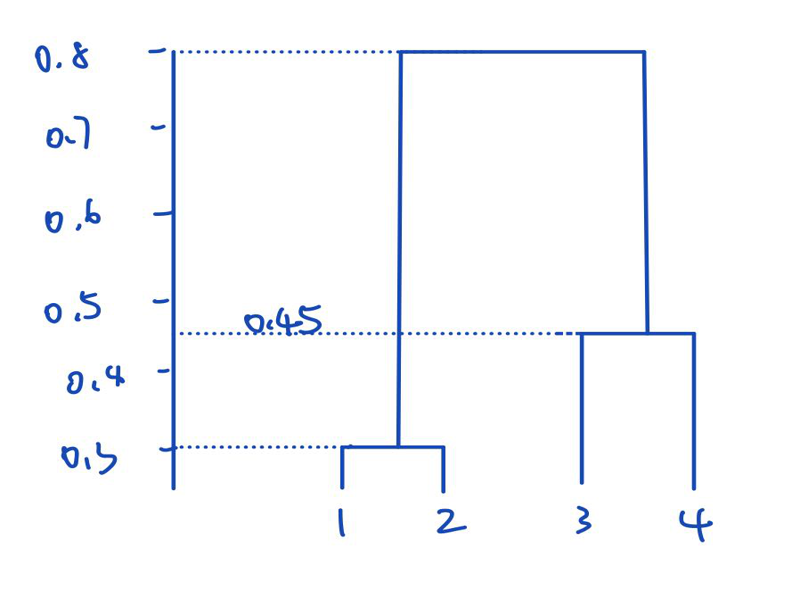

In [208]:
image_path = '/Users/daiqiaochu/Desktop/WechatIMG65.jpg'
img = Image.open(image_path)
display(img.resize((800, 600)))

##### (b). Repeat (a), this time using single linkage clustering

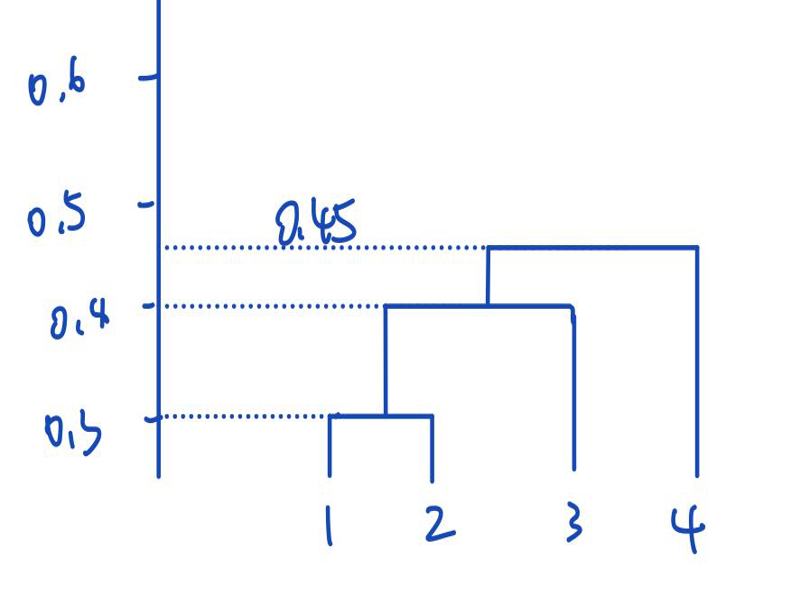

In [209]:
image_path = '/Users/daiqiaochu/Desktop/WechatIMG66.jpg'
img = Image.open(image_path)
display(img.resize((800, 600)))

##### (c). Suppose that we cut the dendogram obtained in (a) such that two clusters result. Which observations are in each cluster?

Cluster 1: {1,2}
Cluster 2: {3,4}

##### (d). Suppose that we cut the dendogram obtained in (b) such that two clusters result. Which observations are in each cluster?

Cluster 1: {1,2,3}
Cluster 2: {4}

##### (e). It is mentioned in the chapter that at each fusion in the dendrogram, the position of the two clusters being fused can be swapped without changing the meaning of the dendrogram. Draw a dendrogram that is equivalent to the dendrogram in (a), for which two or more of the leaves are repositioned, but for which the meaning of the dendrogram is the same



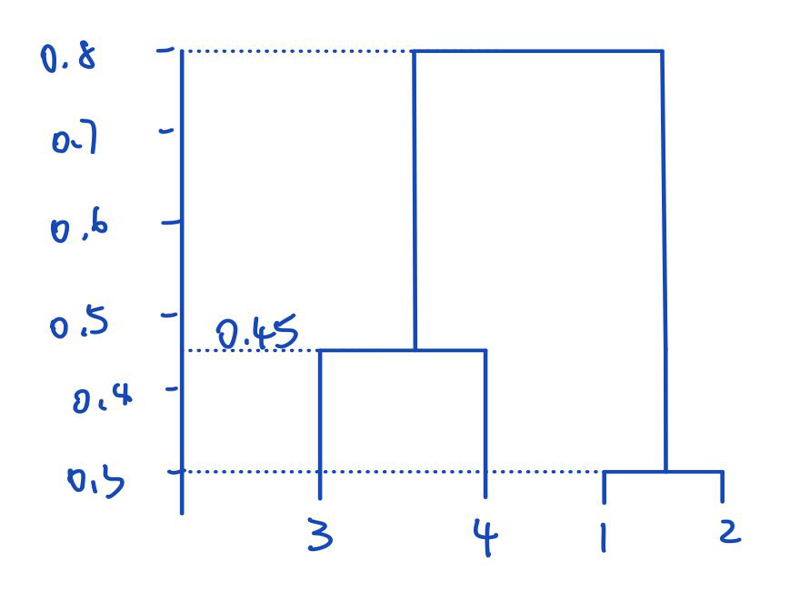

In [210]:
image_path = '/Users/daiqiaochu/Desktop/WechatIMG67.jpg'
img = Image.open(image_path)
display(img.resize((800, 600)))